In [15]:
import numpy as np
import pandas as pd
import starry
from plot_starry import plot_animation, plot_curve
from math_utils import calc_veq, calc_prot
import scipy.stats as stats

starry.config.lazy = False
starry.config.quiet = True

In [27]:
def calc_veq(P, rstar=1.0):
    """
    Calculate the equatorial velocity (in km/s)
    from the rotation period (in days) and stellar radius (in Rsolar)
    """
    from astropy import units as u

    P *= u.day
    rstar *= u.Rsun

    return (2. * np.pi * rstar / P).to(u.km / u.s).value

def calc_prot(veq, rstar=1.0):
    """
    Calculate rotational period in days given equatorial velocity in km/s and
    stellar radius in Rsun.
    """
    from astropy import units as u

    veq *= (u.km/u.s)
    rstar *= u.Rsun

    return (2. * np.pi * rstar / veq).to(u.day).value


In [28]:
def hour_cadence(tmin=0.0, tmax=30.0):
    """
    1 month with 1 hour cadence
    """
    return np.arange(tmin, tmax, 60./1440.)

In [29]:
def eta(r0, c0, t0, t, tau=0.1):
    """
    Exponetial decay function for spots. Contrast decays
    twice as fast as radius.

    ::Params::
    ==========
    c0 (float or array): initial contrast of spot
    r0 (float or array): initial radius of spot
    t0 (float or array): random choice for start of spot lifetime
    t (float): current timestep in star lifetime
    tau (int, optional):
        decay factor, arbitrarily set to 0.1,
        there should be a more intelligent choice here?

    ::Returns::
    ===========
    r, c : float
        spot radius and contrast at timestep t
    """

    # calculate the time difference between the spot's maximum
    # contrast (t0) and current time (t), set to absolute
    # to account for user error and/or the set coming in vs. out
    delta_t = np.abs(t - t0)
    r, c = r0 * np.exp(-delta_t*tau), c0 * np.exp(-delta_t*tau*2.0)

    return r, c

In [37]:
def initial_spot_params(N, t, rmax=7.5, rmin=1.5, cmax=0.225, cmin=0.075):
    """
    Randomly generate arrays of parameters to create spots parameters drawn
    from a uniform prior distribution.

    ::Params::
    ==========
    N (int): number of spots
    t (array): time array of the light curve
    rmax (float, optional): maximum spot radius, default to 15
    rmin (float, optional): minimum spot radius, default to 3.0 deg
    cmax, cmin (floats, optional):
        max/min of contrast, defaul to 0.1 and 0.25.

    ::Returns::
    ===========
    r_vec, c_vec, lat_vec, lon_vec, t_vec : arrays
        arrays of len N. lat ranges from -90 to 90 and l -180 to 180 [deg]
        t ranges from 0 to maximum [arbitrary units]
    """
    r_vec = np.random.uniform(low=rmin, high=rmax, size=N)
    c_vec = np.random.uniform(low=cmin, high=cmax, size=N)
    lat_vec = np.random.uniform(low=-90., high=90., size=N)
    #lat_vec = np.random.uniform(low=[-90., 30.], high=[-30., 90.], size=(int(N/2)+1, 2))
    #lat_vec = lat_vec.flatten()[:N]
    lon_vec = np.random.uniform(low=-180, high=180, size=N)
    t_vec = np.random.uniform(low=min(t), high=max(t), size=N)

    return r_vec, c_vec, lat_vec, lon_vec, t_vec

def angle_diff(lat, lon, spot_lat, spot_lon):
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    spot_lat, spot_lon = np.deg2rad(spot_lat), np.deg2rad(spot_lon)

    delta_lon = np.abs(lon - spot_lon)
    sines = np.sin(lat) * np.sin(spot_lat)
    cosines = np.cos(lat)*np.cos(spot_lat)*np.cos(delta_lon)

    return np.rad2deg(np.arccos(sines+cosines))

def spot_c(arc_length, spot_radius):
    norm = stats.norm.pdf(0.0, 0.0, spot_radius)
    return stats.norm.pdf(arc_length, 0.0, spot_radius) / norm

In [38]:
def save_spot_params(r_vec, c_vec, lat_vec, lon_vec, t_vec, fn):

    spot_params = {'Radius':r_vec, 'Contrast':c_vec, 'Latitude':lat_vec,
                   'Longitude':lon_vec, 'T0':t_vec}

    spot_params = pd.DataFrame.from_dict(spot_params)

    spot_params.to_csv(fn+'.csv')

def load_spot_params(fn):

     spots = pd.read_csv(fn+'.csv')

     r_vec = spots["Radius"].to_numpy()
     c_vec = spots["Contrast"].to_numpy()
     lat_vec = spots["Latitude"].to_numpy()
     lon_vec = spots["Longitude"].to_numpy()
     t_vec = spots["T0"].to_numpy()

     return r_vec, c_vec, lat_vec, lon_vec, t_vec

In [106]:
def add_spot(p, spot_lats, spot_lons, spot_radius, spot_contrast, lat, lon, N_spot=1):
    """
    Add a spot on the stellar surface map at the pixel level
    """
    p_i = p.copy()

    for s in range(N_spot):
        arc_length = angle_diff(lat, lon, spot_lats[s], spot_lons[s])
        p_i *= (1.0 - spot_contrast[s]*spot_c(arc_length, spot_radius[s]))
    
    return p_i

In [114]:
def spotted_map(N, inc, obl, ydeg=20, udeg=2, q1=0.2, q2=0.1, alpha=0.0,
           t=None, t_step=None, t_min=0.0, t_max=20.0,
           veq=5., prot=None, rstar=1.0, animate=False,
           calc_rv=True, rv_cadence=None, rv_int=None,
           f_err=False, rv_err=False,
           save_spots=True, load_spots=False, tau=0.1):
    """
    Calculate the light curve flux and radial velocity curve of a star (i.e.,
    a starry map) with a population of spots.

    Change Log:
    v. 28.09.21
        No occultor. Removed all calls to starry.map that were unnecessary,
        especially in the for loop to add spots, as well as in the add_spot
        function itself. Reduces computation time by ~2 orders of magnitude.
    v. 02.08.21
        No occultor. RVs. Spots added via "get_pixel_transforms" instead of
        "spots". Note: Add rv_cadence, with rv_int parameter that averages
        across all points within RV_midpoint +/- 0.5*RV_int. Can do this with
        a linearly interpolated version of the RV curve, since it cost very
        little to also compute the supersampled (i.e., sampled at the
        photometric light curve cadence)
    v. 23.08.21
        No occultor. Light curve and map.

    ::Args::
    ==========
    N (int): Number of spots.
    inc (float): Inclination of star in deg.
    obl (float): Stellar obliquity in deg.
    ydeg (int, optional): Max spherical harmonic angle, defaults to 20.
    udeg (int, optional): Limb-darkening degree. Defaults to 2.
    q1 (float, optional): First limb-darkening coefficient. Defaults to 0.2.
    q2 (float, optional): Second limb-darkening coefficient.
        Only used if udeg == 2. Defaults to 0.1.
    t (array-like or int, optional): Time over which to compute
        the flux/rv curve. If array, uses that as timestep.
        If int, then calculates time array as np.linspace(t_min, t_max, t).
        t_step argument overrides this one. Units of [days].
        Defaults to np.linspace(t_min, t_max, 50).
    t_step (float, optional): Time step. If this is given, will supercede
        t parameter. Constructs array as np.arange(t_min, t_max, t_step).
    t_min (float, optional): Minimum time. Defaults to 0 [days].
    t_max (float, optional): Maximum time. Defaults to 30.0 [days].
    veq (float, optional): Equatorial velocity of the star. Defaults to 5 km/s.
    prot (float, optional): Stellar rotational period in [days].
        This is used to calculate the rotation speed. Defaults to None but
        then calculated using veq and rstar. If parameter is given,
        will supercede veq parameter and calculate based on prot and rstar.
    rstar (float, optional): stellar radius in Rsun, used to calculate eq vel
        or rot per. Defaults to 1.0 solar radius.
    animate (boolean, optional): Return image array for animation. Defaults to False.
    calc_rv (boolean, optional): Defaults to True. Returns rv array.
    rv_cadence (array, optional): If not None, calculates RVs at the time
        position specified. The returned rv array is calculated as the average
        of all RV points at the rv_cadence position +/- 0.5*rv_int. The RV
        points average are taken from a supersampled, linearly interpolated
        version of the RV curve.
    rv_int (array, optional): If not None, used to calculate RV values at
        rv_cadence values. If rv_cadence is given but rv_int is not, rv_int
        defaults to 300 s (5 min). Units of seconds.

    ::Returns::
    ===========
    t (array): Time array.
    theta (array): Theta array of length t.
    f (array): Flux array of length t.

    rv (array): RV array. Length t or length rv_cadence.
    t_rv (array): RV time array.
    """

    if t_step is not None:
        t = np.arange(t_min, t_max, t_step)
    elif t is not None:
        if isinstance(t, np.ndarray):
            t = t
        elif isinstance(t, int):
            t = np.linspace(t_min, t_max, t)
    else:
        t = np.linspace(t_min, t_max, 50)

    if animate:
        res = 300
        image = np.empty((len(theta), res, res))

    if prot is None:
        prot = calc_prot(veq, rstar=rstar)
    else:
        veq = calc_veq(prot, rstar=rstar)

    theta = 360.0 / prot * t
    f = np.zeros_like(t)

    # Create the stellar map using input orientation
    map = starry.Map(ydeg=int(ydeg), inc=inc, obl=obl,
                     udeg=int(udeg), rv=calc_rv)
    if udeg >= 1:
        map[1] = q1
    if udeg == 2:
        map[2] = q2
    if calc_rv:
        map.veq = veq * 1e4
        map.alpha = alpha

        rv = np.zeros_like(t)

        # Calculate the B matrix (for the RVs)
        rv_f = map.ops.compute_rv_filter(map._inc, map._obl, map._veq, map._alpha)
        kwargs = {"xo":0.0, "yo":0.0, "zo":1.0, "ro":0.0, "theta":theta}
        theta_hold, xo, yo, zo, ro = map._get_flux_kwargs(kwargs)
        B = map.ops.X(theta_hold, xo, yo, zo, ro, map._inc, map._obl, map._u, rv_f)

    A = map.design_matrix(theta=theta) # design matrix, A
    y_nt = np.zeros((len(map.y), len(t))) # y matrix of y vectors at time t
    lat, lon, Y2P, P2Y, Dx, Dy = map.get_pixel_transforms() # pixel transformations
    p = Y2P.dot(map.y) # pixels

    # Create (or load) spots
    spot_params_base = 'Simulated Data/' + 'Decay Rate' + '/N{0:d}_inc{1:.1f}_obl{2:.1f}_P{3:.1f}/'.format(N, inc, obl, prot)
    spot_params_end = 'spot_params'
    spot_params_fn = spot_params_base + spot_params_end

    if load_spots:
        r_vec, c_vec, lat_vec, lon_vec, t_vec = load_spot_params(spot_params_fn)
    else:
        r_vec, c_vec, lat_vec, lon_vec, t_vec = initial_spot_params(N, t)
    if save_spots:
        save_spot_params(r_vec, c_vec, lat_vec, lon_vec, t_vec, spot_params_fn)
    
    for i in range(len(t)): # At every time step, calculate the flux
        
        r, c = eta(r_vec, c_vec, t_vec, t[i], tau=tau)  # Decay spots
        p_i = add_spot(p, lat_vec, lon_vec, r, c, N_spot=N,
                       lat=lat, lon=lon) # pixel-level surface map changes

        if animate:
            image[i] = map.render(theta=theta[i], res=res) # map image at t

        y_nt[:,i] = P2Y.dot(p_i)

    # Take the full design matrix and dot it into spherical harmonic matrix
    # Need to take the diagonal since you want the flux at each time step, i
    f = np.diagonal(A.dot(y_nt)).copy()
    if calc_rv:
        rv = np.diagonal(B.dot(y_nt)).copy() / f

    # Add photometric error to light curve
    if f_err:
        if isinstance(f_err, np.ndarray):
            f_err = f_err
        elif isinstance(f_err, float):
            f_err = f_err * np.random.randn(len(f))
        else:
            f_err = 2.5e-4 * np.random.randn(len(f)) # Kepler?

        f += f_err
    else:
        f_err = None

    # Add instrumental error to RV curve
    if rv_err:
        if isinstance(rv_err, np.ndarray):
            rv_err = rv_err
        elif isinstance(rv_err, float):
            rv_err = rv_err * np.random.randn(len(rv))
        else:
            #rv_err = (np.nanstd(rv) / 200.) * 35. * np.random.randn(len(rv)) # HPF?
            rv_err = 15. * np.random.randn(len(rv)) # HPF?

        rv += rv_err
    else:
        rv_err = None

    if rv_cadence is not None:
        from scipy.interpolate import interp1d

        sec_to_day = 1.157e-5

        # default to 300 second integration time (HPF)
        if rv_int is None:
            rv_int = 300.

        rv_int_range = 0.5*rv_int*sec_to_day

        # interpolate rv curve
        rv_interp_func = interp1d(t, rv, kind='cubic')

        sampled_rv = np.zeros_like(rv_cadence)
        for i in range(len(rv_cadence)):
            # average all rv values at rv_cadence -0.5*rv_int to +0.5*rv_int
            rv_cadence_int = np.arange(rv_cadence[i] - rv_int_range, rv_cadence[i] + rv_int_range, 1.157e-5)
            sampled_rv[i] = np.nanmean(rv_interp_func(rv_cadence_int))

    returns = [t, f]

    if f_err is not None:
        returns += [f_err]
    if animate:
        returns += [theta, image]
    if calc_rv:
        returns += [rv]
        if rv_err is not None:
            returns += [rv_err]
        if rv_cadence is not None:
            returns += [sampled_rv, rv_cadence]

    return returns

In [108]:
N, inc, obl, prot, veq = 25, 88.0, 4.0, 8.0, calc_veq(8.0)
tau = 0.1

t = hour_cadence(tmin=0.0, tmax=27.4)

base_fn = 'N{0:d}_inc{1:.1f}_obl{2:.1f}_P{3:.1f}'.format(N, inc, obl, prot)
base_name = "Decay Rate/" + base_fn + "/tau_{0:.3f}".format(tau)

In [109]:
t, f, rv, rv_err = spotted_map(N=N, inc=inc, obl=obl, prot=prot,
                               t=t, calc_rv=True, f_err=False, rv_err=True, tau=tau,
                               load_spots=True)

In [110]:
old_t = np.load("Simulated Data/" + base_name + "_t.npy")
old_f = np.load("Simulated Data/" + base_name + "_f.npy")
f_err = np.load("Simulated Data/" + base_name + "_ferr.npy")

old_f -= f_err

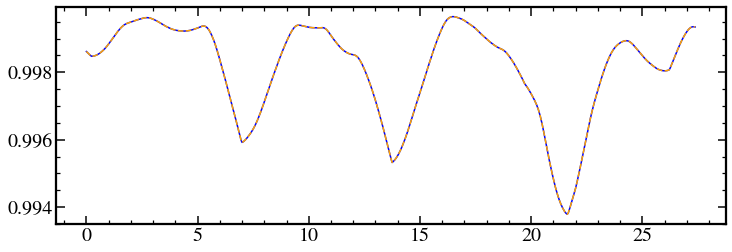

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(t, f, color='blue')
ax.plot(old_t, old_f, color='orange', ls='--')

plt.show()